In [1]:
import math
import numpy as np
import numpy.random as npr
from numpy import linalg
import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset
import torch.optim as optim
import time
from useful_tools import isPointinPolygon,polyshow,Genpoint,Distance_pol,GenBC
from network import ResNet
from math import *
torch.cuda.set_device(0)

In [2]:
def sol_exact(x):
    return torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)
def sol_exact_H1(x):
    sol = torch.zeros(x.shape[0],dim_set+1).cuda()
    sol[:,0:1] = torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)
    sol[:,1:dim_set+1] = pi*torch.cos(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)
    return sol

In [3]:
def right(x):
    return -dim_set*pi**2*torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)

In [4]:
dim_set = 16
Batch_size = 50000
def DGM1():
    x = torch.rand(Batch_size,dim_set).cuda()
    x.requires_grad = True
    u = model_u(x)
    du = model_p(x)
    r = model_r(x)
    v= torch.ones(u.shape).cuda()
    ux = torch.autograd.grad(u,x,grad_outputs=v,create_graph=True)[0]
    loss1 = torch.sum((ux-du)**2)/Batch_size+torch.sum((r-u-du)**2)/Batch_size
    return loss1

In [5]:
def DGM2():
    x = torch.rand(Batch_size,dim_set).cuda()
    x.requires_grad = True
    u = model_u(x)
    du = model_p(x)
    v= torch.ones(u.shape).cuda()
    uxx = torch.zeros(Batch_size,dim_set).cuda()
    for i in range(dim_set):
        ux_tem = du[:,i].reshape([x.size()[0],1])
        uxx_tem = torch.autograd.grad(ux_tem,x,grad_outputs=v,create_graph=True)[0]
        uxx[:,i] = uxx_tem[:,i]
    loss2 = torch.sum((torch.sum(uxx,dim=1).reshape([x.size()[0],1]) - right(x))**2)/Batch_size
    return loss2

In [6]:
model_u = ResNet(dim_set,40,1)
model_r1 = ResNet(dim_set,40,dim_set)

device=torch.device("cuda:0" )
model_u.to(device)
model_r1.to(device)

ResNet(
  (fc1): Linear(in_features=16, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=40, bias=True)
  (outlayer): Linear(in_features=40, out_features=16, bias=True)
)

In [7]:
def model_r(x):
    return x*(1-x)*model_r1(x) + torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1) + pi * torch.cos(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)

In [8]:
def model_p(x):
    return model_r(x)-model_u(x)

In [9]:
def loss_error():
    notes_error = torch.rand(10000,dim_set).cuda()
    notes_error.requires_grad= True
    exact = sol_exact_H1(notes_error)
    u_L2 = sqrt(torch.sum((exact[:,0])**2)/10000)
    Du_L2 = sqrt(torch.sum(exact[:,1:dim_set+1]**2)/10000)
    predict = torch.zeros(10000,2*dim_set+2).cuda()
    predict[:,0]= model_u(notes_error).reshape([1,notes_error.size()[0]])
    predict[:,1:dim_set+1]= model_p(notes_error)
    value1 = sqrt(torch.sum((predict[:,0] - exact[:,0])**2)/10000)/u_L2
    value2 = sqrt(torch.sum((predict[:,1:dim_set+1] - exact[:,1:dim_set+1])**2)/10000)/Du_L2
    return value1,value2

In [10]:
traintime = 50000
error_save=np.zeros([2,traintime])
optimizer = optim.Adam([
                {'params': model_r1.parameters()},
                {'params': model_u.parameters()}
            ])
i = 0
time_start=time.time()
for i in range(traintime):
    optimizer.zero_grad()
    losses = DGM1()+DGM2()
    losses.backward()
    optimizer.step() 
    error1,error2 = loss_error()
    error_save[0,i]=float(error1)
    error_save[1,i]=float(error2)
    i = i +1
    if i%500==1:
        print("i= ",i)
        print("error =",error1)
        print("loss1 =",losses.detach())
        np.save("error_save_LDG_Robin_16D_w40.npy", error_save)
np.save("error_save_LDG_Robin_16D_w40.npy", error_save)
time_end=time.time()
print('time cost',time_end-time_start,'s')

i=  1
error = 1.0020689270199583
loss1 = tensor(1358.4702, device='cuda:0')
i=  501
error = 0.533740768110839
loss1 = tensor(39.9060, device='cuda:0')
i=  1001
error = 0.37228150752021333
loss1 = tensor(9.2252, device='cuda:0')
i=  1501
error = 0.25059796374838417
loss1 = tensor(6.4495, device='cuda:0')
i=  2001
error = 0.1916334505053311
loss1 = tensor(3.2893, device='cuda:0')
i=  2501
error = 0.16741146191243625
loss1 = tensor(2.4553, device='cuda:0')
i=  3001
error = 0.15334485536266199
loss1 = tensor(2.1783, device='cuda:0')
i=  3501
error = 0.14206363761313748
loss1 = tensor(2.7562, device='cuda:0')
i=  4001
error = 0.11093234266498127
loss1 = tensor(1.4980, device='cuda:0')
i=  4501
error = 0.11025109475978545
loss1 = tensor(1.6944, device='cuda:0')
i=  5001
error = 0.0848260896149187
loss1 = tensor(1.1646, device='cuda:0')
i=  5501
error = 0.08307930606427225
loss1 = tensor(1.5666, device='cuda:0')
i=  6001
error = 0.07455551983342883
loss1 = tensor(1.3176, device='cuda:0')
i=  

In [11]:
import matplotlib.pyplot as plt
x = np.arange(0,1,0.001)
notes= torch.rand(1000,4).cuda()
notes[:,0:3] = 0
notes[:,3] = torch.tensor(x)

In [12]:
u_e = sol_exact_H1(notes)[:,0:1]
p_e = sol_exact_H1(notes)[:,1:4]

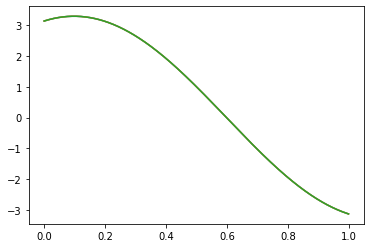

In [13]:
plt.plot(x,(u_e+p_e).cpu().detach().numpy())

In [14]:
u =  model_u(notes)
p =  model_p(notes)
r =  model_r(notes)
plt.plot(x,(r).cpu().detach().numpy())

RuntimeError: size mismatch, m1: [1000 x 4], m2: [16 x 40] at /opt/conda/conda-bld/pytorch_1587428111115/work/aten/src/THC/generic/THCTensorMathBlas.cu:283